### 本日課程重點：使用Naive Bayes模型完成情感分析
* 資料來源：https://www.kaggle.com/crowdflower/twitter-airline-sentiment

In [1]:
import numpy as np
import pandas as pd
data = pd.read_csv(r'D23_Naive Bayes 實作 (單純貝氏)_Tweets.csv')
display(data.head(5))

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [2]:
display(data[['text','airline_sentiment']])

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative


In [3]:
label_to_index = {"negative": 0, "neutral": 1, "positive": 2}

In [4]:
## 去除開頭航空名稱 ex. @VirginAmerica
X = data['text'].apply(lambda x: ' '.join(x.split(' ')[1:])).values
## 將negative, neutral, postive 轉換為 0,1,2
Y = data['airline_sentiment'].apply(lambda x: label_to_index[x]).values

### 文字預處理

In [5]:
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
import re
import nltk
nltk.download('stopwords')
# Lemmatize with POS Tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 

## 創建Lemmatizer
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """將pos_tag結果mapping到lemmatizer中pos的格式"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def clean_content(X):
    # remove non-alphabet characters
    X_clean = [re.sub('[^a-zA-Z]',' ', str(x)).lower() for x in X]
    # tokenize
    X_word_tokenize = [nltk.word_tokenize(x) for x in X_clean]
    # stopwords_lemmatizer
    X_stopwords_lemmatizer = []
    stop_words = set(stopwords.words('english'))
    for content in X_word_tokenize:
        content_clean = []
        for word in content:
            if word not in stop_words:
                word = lemmatizer.lemmatize(word, get_wordnet_pos(word))
                content_clean.append(word)
        X_stopwords_lemmatizer.append(content_clean)
    X_output = [' '.join(x) for x in X_stopwords_lemmatizer]
    return X_output

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
X = clean_content(X)

### Bag of words

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
#max_features是要建造幾個column，會按造字出現的頻率高低去篩選，3600並沒有特別含義(筆者測試幾次最佳結果)
#大家可以自己嘗試不同數值或不加入限制
cv=CountVectorizer(max_features = 3600)
X_T=cv.fit_transform(X).toarray()

In [8]:
# 有 14640 個樣本，每個樣本用3600維表示
X_T.shape 

(14640, 3600)

### 將資料拆成 train/test set

In [9]:
from sklearn.model_selection import train_test_split
# random_state 是為了讓各為學員得到相同的結果，平時可以移除
X_train, X_test, y_train, y_test = train_test_split(X_T, Y, test_size = 0.2, random_state = 0)

### 畫出 Confusion Matrix 結果

In [10]:
from sklearn.metrics import confusion_matrix
def plot_cm_output(cm, labels=['negative', 'neutral', 'positive']):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm,cmap=plt.cm.Blues,)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

### Naive Bayes

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
%matplotlib inline

## 測試 train/testset的 Accuracy

---

#### MultinomialNB

In [12]:
clf_M = MultinomialNB()
clf_M.fit(X_train, y_train)

MultinomialNB()

In [13]:
for i in ['train', 'test']:
    print(f'{i.capitalize()}set Accuracy: {clf_M.score(globals()["X_"+i], globals()["y_"+i])}')

Trainset Accuracy: 0.8206967213114754
Testset Accuracy: 0.7694672131147541


In [14]:
output_ = clf_M.predict(X_test)
cm_output = confusion_matrix(y_test, output_)
print(cm_output)

[[1664  141   65]
 [ 253  310   51]
 [ 107   58  279]]


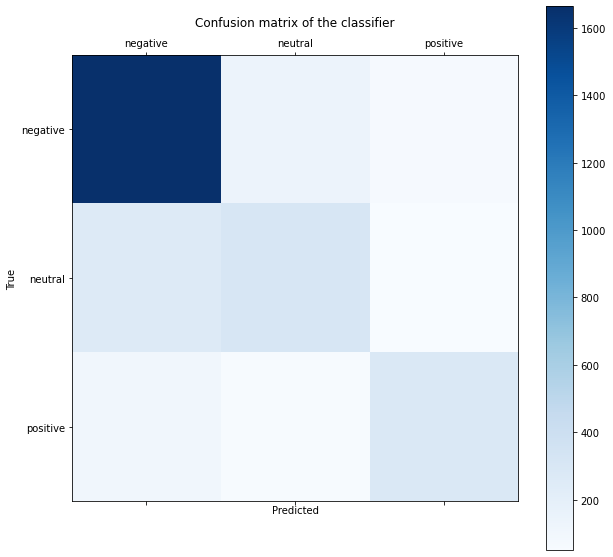

In [15]:
plot_cm_output(cm_output)

#### BernoulliNB

#### 將BOW的標注轉換為『文字是否出現在段落內』，以符合BernoulliNB的假設(所有特徵皆為二元)

In [16]:
X_train[X_train>1] = 1
X_test[X_test>1] = 1

In [17]:
clf_B = BernoulliNB()
clf_B.fit(X_train, y_train)

BernoulliNB()

In [18]:
for i in ['train', 'test']:
    print(f'{i.capitalize()}set Accuracy: {clf_B.score(globals()["X_"+i], globals()["y_"+i])}')

Trainset Accuracy: 0.8304303278688525
Testset Accuracy: 0.7776639344262295


In [19]:
output_ = clf_B.predict(X_test)
cm_output = confusion_matrix(y_test, output_)
print(cm_output)

[[1631  167   72]
 [ 201  354   59]
 [  91   61  292]]


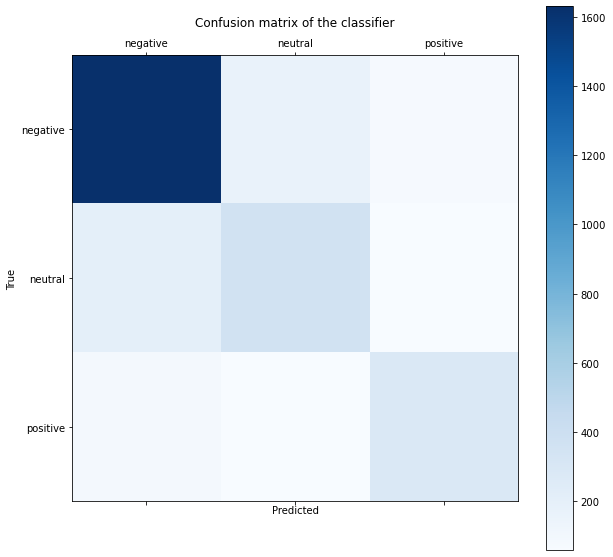

In [20]:
plot_cm_output(cm_output)